In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
store_sales = pd.read_csv("train.csv")
store_sales.head(30)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


Clearing of the Dataset (pre-processing)

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883989 entries, 0 to 883988
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    883989 non-null  object
 1   store   883989 non-null  int64 
 2   item    883989 non-null  int64 
 3   sales   883989 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.0+ MB


In [ ]:
store_sales = store_sales.drop(['store','item'],axis = 1)
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883989 entries, 0 to 883988
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    883989 non-null  object
 1   sales   883989 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.5+ MB


In [ ]:
#change of data type for data
store_sales['date'] = pd.to_datetime(store_sales['date'])
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883989 entries, 0 to 883988
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    883989 non-null  datetime64[ns]
 1   sales   883989 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.5 MB


In [ ]:
store_sales['date'] = store_sales['date'].dt.to_period("M")
monthly_sales = store_sales.groupby('date').sum().reset_index()
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

Verification

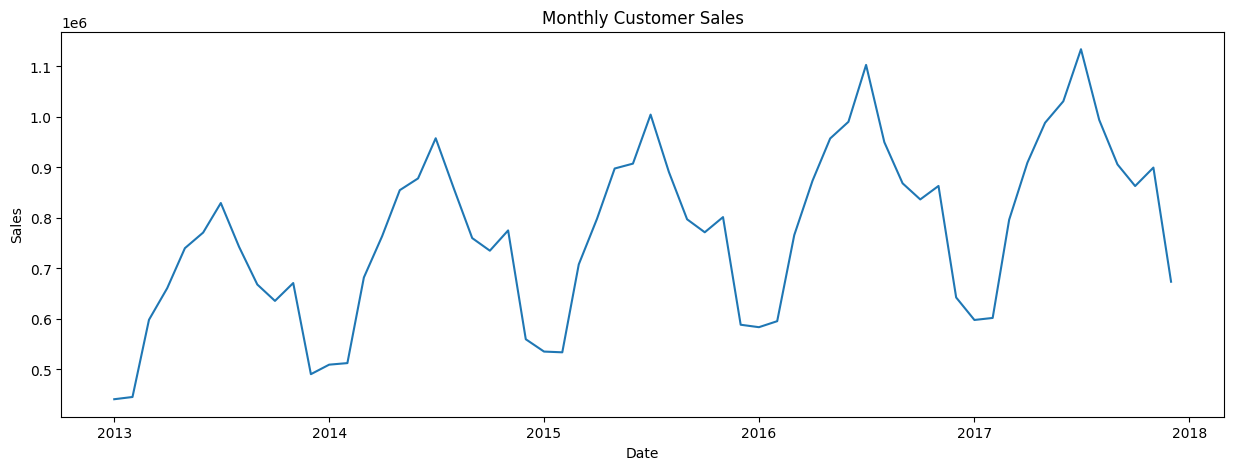

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales")
plt.show()

In [ ]:
 monthly_sales['sale_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)
# this takes into account the diif between the previous and current month

,date,sales,sale_diff
1,2013-02-01,445407,4423.0
2,2013-03-01,598273,152866.0
3,2013-04-01,661003,62730.0
4,2013-05-01,740106,79103.0
5,2013-06-01,771020,30914.0
6,2013-07-01,829557,58537.0
7,2013-08-01,742795,-86762.0
8,2013-09-01,668163,-74632.0
9,2013-10-01,635705,-32458.0
10,2013-11-01,671073,35368.0


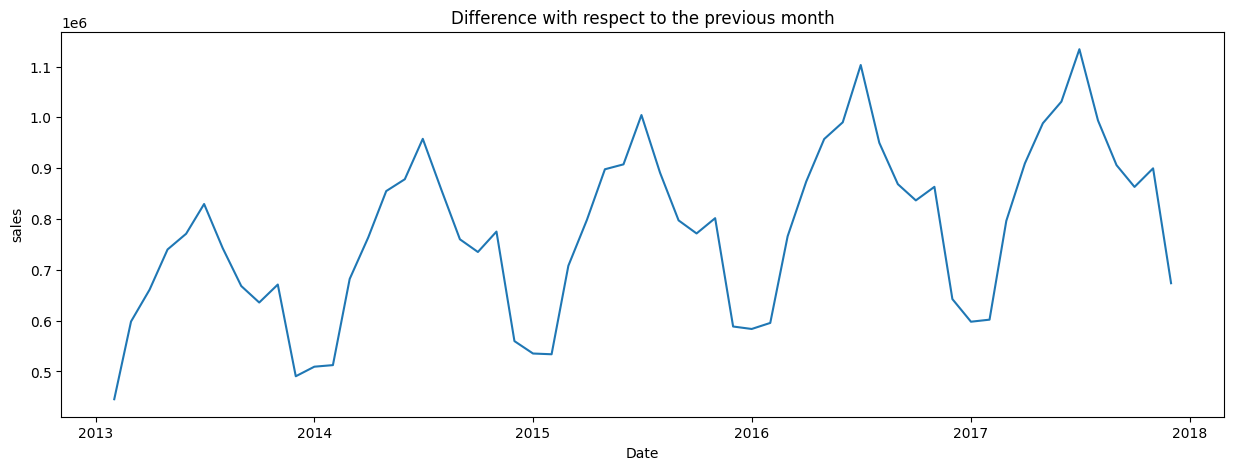

In [ ]:
plt.figure(figsize = (15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel('sales')
plt.title('Difference with respect to the previous month')
plt.show()

In [ ]:
#Creating the Linear Regression Model
supervised_data = monthly_sales.drop(['date','sales'],axis = 1)
for i in range(1,13):
  col_name = 'month' + str(i)
  supervised_data[col_name] = supervised_data['sale_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop = True)
supervised_data.head(10)

,sale_diff,month1,month2,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12
0,3091.0,18845.0,-180494.0,35368.0,-32458.0,-74632.0,-86762.0,58537.0,30914.0,79103.0,62730.0,152866.0,4423.0
1,169551.0,3091.0,18845.0,-180494.0,35368.0,-32458.0,-74632.0,-86762.0,58537.0,30914.0,79103.0,62730.0,152866.0
2,81797.0,169551.0,3091.0,18845.0,-180494.0,35368.0,-32458.0,-74632.0,-86762.0,58537.0,30914.0,79103.0,62730.0
3,91141.0,81797.0,169551.0,3091.0,18845.0,-180494.0,35368.0,-32458.0,-74632.0,-86762.0,58537.0,30914.0,79103.0
4,23267.0,91141.0,81797.0,169551.0,3091.0,18845.0,-180494.0,35368.0,-32458.0,-74632.0,-86762.0,58537.0,30914.0
5,79539.0,23267.0,91141.0,81797.0,169551.0,3091.0,18845.0,-180494.0,35368.0,-32458.0,-74632.0,-86762.0,58537.0
6,-100172.0,79539.0,23267.0,91141.0,81797.0,169551.0,3091.0,18845.0,-180494.0,35368.0,-32458.0,-74632.0,-86762.0
7,-97548.0,-100172.0,79539.0,23267.0,91141.0,81797.0,169551.0,3091.0,18845.0,-180494.0,35368.0,-32458.0,-74632.0
8,-24961.0,-97548.0,-100172.0,79539.0,23267.0,91141.0,81797.0,169551.0,3091.0,18845.0,-180494.0,35368.0,-32458.0
9,40139.0,-24961.0,-97548.0,-100172.0,79539.0,23267.0,91141.0,81797.0,169551.0,3091.0,18845.0,-180494.0,35368.0


In [ ]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print("Train Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)

Train Data Shape: (35, 13)
Test Data Shape: (12, 13)


In [ ]:
scaler = MinMaxScaler(feature_range = (-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
train_data = scaler.transform(test_data)


In [ ]:
# Apply scaler transform to test_data, not train_data
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data) # Transform test_data

# Convert transformed data to numpy arrays
train_data = np.array(train_data)
test_data = np.array(test_data)

# Now you can use numpy slicing
x_train, y_train = train_data[:, 1:], train_data[:, 0:1]
x_test, y_test = test_data[:,1:],test_data[:,0:1]

# Convert y_train and y_test to 1D arrays (unchanged)
y_train = y_train.ravel()
y_test = y_test.ravel()

# Printing shapes of the arrays (unchanged)
print("X_train Shape: ", x_train.shape)
print("X_test Shape:", x_test.shape)
print("Y_train Shape:", y_train.shape)
print("Y_test Shape:", y_test.shape)

X_train Shape:  (12, 12)
X_test Shape: (12, 12)
Y_train Shape: (12,)
Y_test Shape: (12,)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop = True)
predict_df = pd.DataFrame(sales_dates)

In [ ]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[642474, 597925, 601962, 796373, 909401, 988422, 1031051, 1134118, 994020, 905992, 863166, 899726, 673671]


In [ ]:
lr_model = LinearRegression()
lr_model.fit(x_train,y_train)
lr_pred = lr_model.predict(x_test)
lr_pred = lr_pred.reshape(-1,1)
lr_pre_test_set = np.concatenate([lr_pred, x_test],axis = 1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)
lr_pred = lr_pre_test_set

In [ ]:
result_list = []
for index in range(0,len(lr_pred)):
  result_list.append(lr_pred[index][0] +act_sales[index])
lr_pre_series = pd.Series(result_list, name = 'Linear Regression')
predict_df = predict_df.merge(lr_pre_series,left_index = True, right_index = True)

In [ ]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Regression'],monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Regression'],monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Regression'],monthly_sales['sales'][-12:])
print("Linear Regression MSE", lr_mse)
print("Linear Regression MAE", lr_mae)
print("Linear Regression R2", lr_r2)


Linear Regression MSE 15668.77044539582
Linear Regression MAE 15593.984766288806
Linear Regression R2 0.9906969469760198


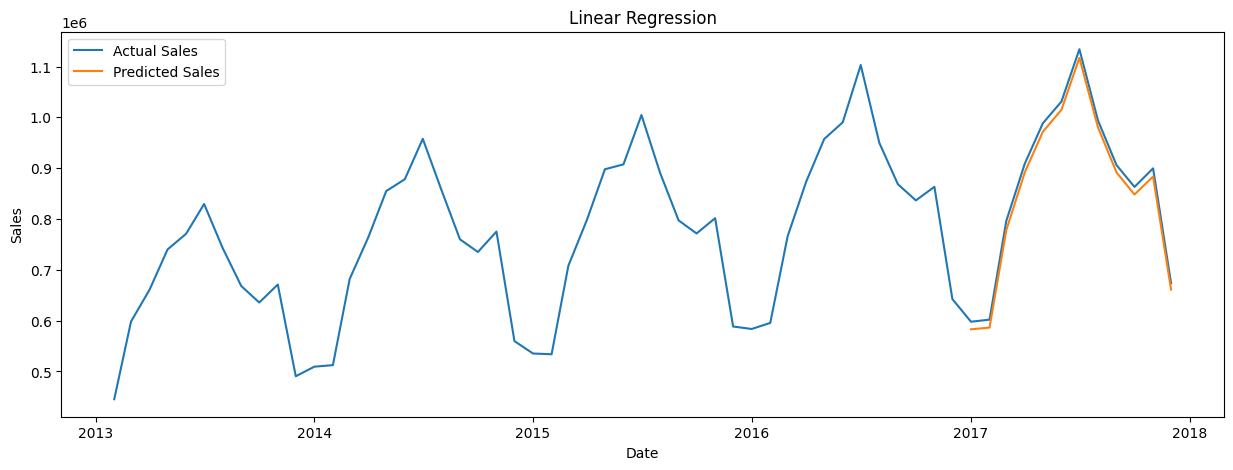

In [ ]:
plt.figure(figsize = (15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'],label = 'Actual Sales')
#Predicted
plt.plot(predict_df['date'],predict_df['Linear Regression'],label = 'Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Linear Regression')
plt.legend()
plt.show()

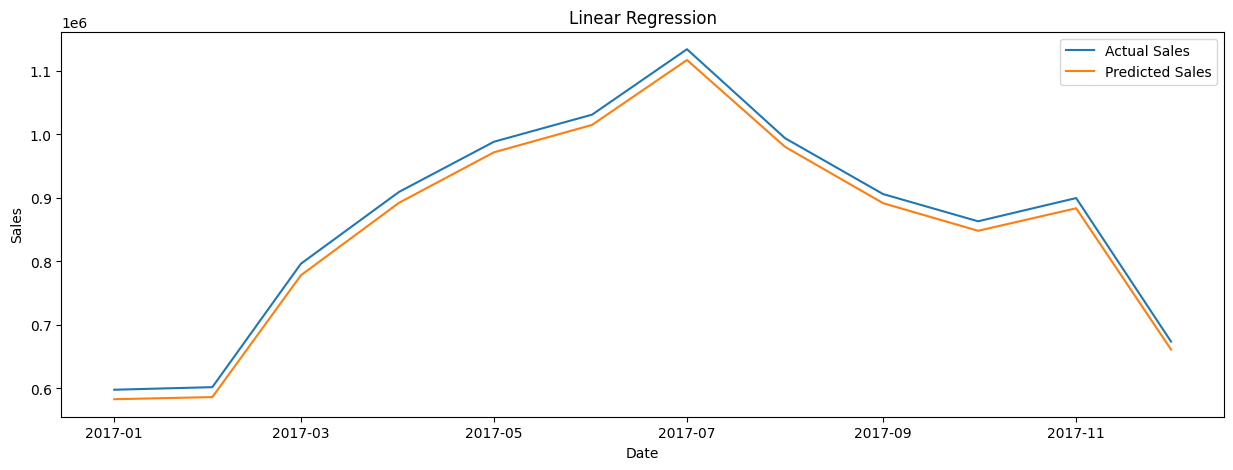

In [ ]:
plt.figure(figsize = (15,5))
plt.plot(monthly_sales['date'][-12:],monthly_sales['sales'][-12:],label = 'Actual Sales')
#Predicted
plt.plot(predict_df['date'],predict_df['Linear Regression'],label = 'Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Linear Regression')
plt.legend()
plt.show()

In [ ]:
ape = np.abs((predict_df['Linear Regression'] - monthly_sales['sales'][-12:]) / monthly_sales['sales'][-12:]) * 100

In [ ]:
mape = np.mean(ape)
print("MAPE:", mape)

MAPE: nan


In [ ]:
# Replace zeros with a small value
actual_sales = monthly_sales['sales'][-12:].replace(0, 1e-10)

# Calculate absolute percentage error
ape = np.abs((predict_df['Linear Regression'] - actual_sales) / actual_sales) * 100

# Remove NaN values (if any)
valid_indices = ~np.isnan(ape)
ape = ape[valid_indices]

# Calculate MAPE
mape = np.mean(ape)
print("MAPE:", mape)

MAPE: nan


In [ ]:
print(predict_df['Linear Regression'])
print(monthly_sales['sales'][-12:])

0     5.829699e+05
1     5.863485e+05
2     7.781801e+05
3     8.923108e+05
4     9.717926e+05
5     1.014915e+06
6     1.117163e+06
7     9.803595e+05
8     8.916260e+05
9     8.481875e+05
10    8.836719e+05
11    6.611751e+05
Name: Linear Regression, dtype: float64
48     597925
49     601962
50     796373
51     909401
52     988422
53    1031051
54    1134118
55     994020
56     905992
57     863166
58     899726
59     673671
Name: sales, dtype: int64


In [ ]:
# Extract actual sales for the last 12 months
actual_sales = monthly_sales['sales'][-12:].values

# Calculate absolute percentage error
ape = np.abs((predict_df['Linear Regression'].values - actual_sales) / actual_sales) * 100

# Calculate MAPE
mape = np.mean(ape)
print("MAPE:", mape)

MAPE: 1.8613025723491374
